In [5]:
import os
from os.path import join
from random import shuffle
from scipy.io import wavfile
import IPython
import librosa

from sklearn.preprocessing import normalize

import numpy as np
import pandas as pd
import scipy.io.wavfile as wav
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import keras
from sklearn.model_selection import train_test_split
from keras.layers import Input, Embedding, LSTM, Dense, concatenate, TimeDistributed
from keras.models import Model
from keras import optimizers

from laughter_classification.utils import chunks, in_any, interv_to_range, get_sname

from laughter_prediction.sample_audio import sample_wav_by_time

In [6]:
LABEL_NAME = "IS_LAUGHTER"
S_NAME = "SNAME"
SAMPLE_RATE = 16000
DURATION = 11
AUDIO_LEN = SAMPLE_RATE*DURATION
FRAME_SEC = 0.1
FRAME_SIZE = int(FRAME_SEC*SAMPLE_RATE)
FRAME_STEP = FRAME_SIZE//2
NUM_CLASSES = 2

# Preparing dataset

Preprocess data, extract filterbank and MFCC features and labels. Noisy dataset was prepared beforehead by script from the first homework.

In [34]:
def extract_features(wav_path):
    """
    Extracts features for classification ny frames for .wav file

    :param wav_path: string, path to .wav file
    :return: pandas.DataFrame with features of shape (n_chunks, n_features)
    """

    rate, audio = wav.read(wav_path)

    # Let's make and display a mel-scaled power (energy-squared) spectrogram

    filterbanks = []
    mfccs = []

    for i in range(0, len(audio) - FRAME_SIZE, FRAME_STEP):
        end = i + FRAME_SIZE
        # Convert to log scale (dB). We'll use the peak power (max) as reference.
        cur_filterbank = librosa.feature.melspectrogram(y=audio.astype(np.float)[i: end], sr=rate)
        filterbanks.append(np.mean(cur_filterbank, axis=1))
        # Next, we'll extract the top 13 Mel-frequency cepstral coefficients (MFCCs)
        cur_mfcc = librosa.feature.mfcc(y=audio.astype(np.float)[i: end], sr=rate)
        mfccs.append(np.mean(cur_mfcc, axis=1))

    filterbank = np.vstack(filterbanks)
    mfcc = np.vstack(mfccs)

    columns_mfcc = list(map(lambda num: 'mfcc_' + str(num), list(range(mfcc.shape[1]))))
    columns_filter = list(map(lambda num: 'filterbank_' + str(num), list(range(filterbank.shape[1]))))
    return pd.DataFrame(mfcc, columns=columns_mfcc), columns_mfcc, \
           pd.DataFrame(filterbank, columns=columns_filter), columns_filter

In [35]:
class SSPNetDataSampler:
    """
    Class for loading and sampling audio data by frames for SSPNet Vocalization Corpus
    """

    @staticmethod
    def read_labels(labels_path):
        def_cols = ['Sample', 'original_spk', 'gender', 'original_time']
        label_cols = ["{}_{}".format(name, ind) for ind in range(6) for name in ('type_voc', 'start_voc', 'end_voc')]
        def_cols.extend(label_cols)
        labels = pd.read_csv(labels_path, names=def_cols, engine='python', skiprows=1)
        return labels

    def __init__(self, data_dir, labels_path):
        self.data_dir = data_dir
        self.labels = self.read_labels(labels_path)

    @staticmethod
    def most(l):
        return int(sum(l) > len(l) / 2)

    @staticmethod
    def _interval_generator(incidents):
        for itype, start, end in chunks(incidents, 3):
            if itype == 'laughter':
                yield int(start * SAMPLE_RATE), int(end * SAMPLE_RATE)

    def get_labels_for_file(self, wav_path, frame_sec):
        sname = get_sname(wav_path)
        sample = self.labels[self.labels.Sample == sname]

        incidents = sample.loc[:, 'type_voc_0':'end_voc_5']
        incidents = incidents.dropna(axis=1, how='all')
        incidents = incidents.values[0]

        rate, audio = wav.read(wav_path)

        laughts = self._interval_generator(incidents)
        laught_along = np.zeros((AUDIO_LEN,))
        for beg, end in laughts:
            laught_along[beg:end] = 1
            
        is_laughter = np.array([self.most(laught_along[i:i + FRAME_SIZE]) for i in range(0, len(audio) - FRAME_SIZE, FRAME_STEP)])

        df = pd.DataFrame({LABEL_NAME: is_laughter,
                           S_NAME: sname})
        return df

    def df_from_file(self, wav_path, frame_sec):
        """
        Returns sampled data by path to audio file
        :param wav_path: string, .wav file path
        :param frame_sec: int, length of each frame in sec
        :return: pandas.DataFrame with sampled audio
        """
        labels = self.get_labels_for_file(wav_path, frame_sec)
        mfcc_features, mfcc_columns, filter_features, filter_columns = extract_features(wav_path)
        df_data = pd.concat([mfcc_features, filter_features, labels], axis=1)
        return df_data, mfcc_columns, filter_columns

    def get_valid_wav_paths(self):
        for dirpath, dirnames, filenames in os.walk(self.data_dir):
            fullpaths = [join(dirpath, fn) for fn in filenames]
            return [path for path in fullpaths if len(wav.read(path)[1]) == AUDIO_LEN]

    def create_sampled_df(self, frame_sec, naudio=None, save_data_path=None, save_mfcc_path=None, force_save=False, fullpaths=None):
        """
        Returns sampled data for whole corpus
        :param frame_sec: int, length of each frame in sec
        :param naudio: int, number of audios to parse, if not defined parses all
        :param save_path: string, path to save parsed corpus
        :param force_save: boolean, if you want to override file with same name
        :return:
        """
        if fullpaths is None:
            fullpaths = self.get_valid_wav_paths()[:naudio]
        
        datas = [self.df_from_file(wav_path, frame_sec) for wav_path in fullpaths]
        dataframes = [data[0] for data in datas]

        colnames = datas[0][1] + datas[0][2]
        colnames.append(LABEL_NAME)
        colnames.append(S_NAME)
        for df in dataframes:
            df.columns = colnames
            
        return dataframes, datas[0][1], datas[0][2]

In [36]:
data, mfcc_names, filter_names = SSPNetDataSampler('vocalizationcorpus/data', 'vocalizationcorpus/labels.txt').create_sampled_df(0.1, 500)

In [37]:
data_noise, mfcc_names, filter_names = SSPNetDataSampler('vocalizationcorpus/noise_data', 'vocalizationcorpus/labels.txt').create_sampled_df(0.05, 500)

# Preparing data for multiple input

Split into test and train. Also make some preparing.

In [38]:
def prepare_data(data):
    data_filter = np.array([df.loc[:, filter_names].values for df in data])
    data_mfcc = np.array([df.loc[:, mfcc_names].values for df in data])
    data_y = np.array([df.loc[:, [LABEL_NAME]].values for df in data])
    return data_filter, data_mfcc, data_y

In [39]:
data_filter, data_mfcc, data_y = prepare_data(data)
data_y = keras.utils.to_categorical(data_y, NUM_CLASSES).reshape(data_y.shape[0], -1, NUM_CLASSES)

In [40]:
data_filter_noise, data_mfcc_noise, data_y_noise = prepare_data(data_noise)
data_y_noise = keras.utils.to_categorical(data_y_noise, NUM_CLASSES).reshape(data_y_noise.shape[0], -1, NUM_CLASSES)

In [41]:
data_mfcc.shape, data_filter.shape

((500, 218, 20), (500, 218, 128))

# Model

Here I use just two LSTM for each of input then one hidden Dense layout and then one Dense layout to output. The model is shown below.

In [42]:
def create_model():
    main_input = Input(shape=(data_mfcc.shape[1], data_mfcc.shape[2]), dtype='float', name='main_input')
    auxiliary_input = Input(shape=(data_filter.shape[1], data_filter.shape[2]), dtype='float', name='aux_input')

    lstm_out = LSTM(100, return_sequences=True)(main_input)
    lstm_aux_out = LSTM(100, return_sequences=True)(auxiliary_input)

    auxiliary_output = TimeDistributed(Dense(2, activation='softmax', name='aux_output'), name='feature_td')(lstm_out)

    x = concatenate([lstm_out, lstm_aux_out])

    main_output = TimeDistributed(Dense(2, activation='softmax', name='aux_output'), name='main_td')(x)

    model = Model(inputs=[main_input, auxiliary_input], outputs=[main_output, auxiliary_output])
    
    model.compile(optimizer='sgd', loss='binary_crossentropy', metrics=['acc'])
    return model

In [43]:
model = create_model()
noise_model = create_model()

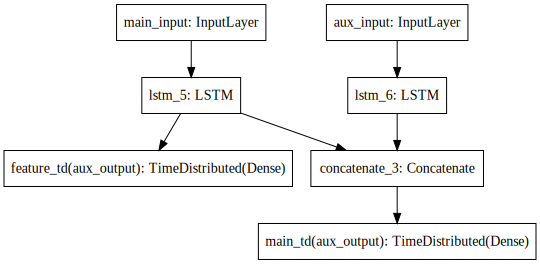

In [44]:
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot

SVG(model_to_dot(model).create(prog='dot', format='svg'))

# Compare noise and pure sounds

In [45]:
from sklearn.metrics import roc_curve, auc

In [46]:
def fit_and_estmate(model, data_mfcc, data_filter, data_y, epochs=15):
    model.fit([data_mfcc, data_filter], [data_y, data_y], validation_split=0.3, epochs=epochs, batch_size=16)

In [47]:
fit_and_estmate(model, data_mfcc, data_filter, data_y, epochs=20)

Train on 350 samples, validate on 150 samples
Epoch 1/20
350/350 [==============================] - 16s 46ms/step - loss: 0.5908 - main_td_loss: 0.3396 - feature_td_loss: 0.2511 - main_td_acc: 0.8902 - feature_td_acc: 0.9541 - val_loss: 0.3870 - val_main_td_loss: 0.1986 - val_feature_td_loss: 0.1885 - val_main_td_acc: 0.9605 - val_feature_td_acc: 0.9605
Epoch 2/20
350/350 [==============================] - 13s 38ms/step - loss: 0.3321 - main_td_loss: 0.1690 - feature_td_loss: 0.1631 - main_td_acc: 0.9666 - feature_td_acc: 0.9666 - val_loss: 0.3504 - val_main_td_loss: 0.1790 - val_feature_td_loss: 0.1714 - val_main_td_acc: 0.9605 - val_feature_td_acc: 0.9605
Epoch 3/20
350/350 [==============================] - 14s 39ms/step - loss: 0.3090 - main_td_loss: 0.1568 - feature_td_loss: 0.1522 - main_td_acc: 0.9666 - feature_td_acc: 0.9666 - val_loss: 0.3425 - val_main_td_loss: 0.1748 - val_feature_td_loss: 0.1676 - val_main_td_acc: 0.9605 - val_feature_td_acc: 0.9605
Epoch 4/20
350/350 [====

In [48]:
fit_and_estmate(noise_model, data_mfcc_noise, data_filter_noise, data_y_noise, epochs=20)

Train on 350 samples, validate on 150 samples
Epoch 1/20
350/350 [==============================] - 15s 43ms/step - loss: 0.5637 - main_td_loss: 0.2867 - feature_td_loss: 0.2771 - main_td_acc: 0.9264 - feature_td_acc: 0.9069 - val_loss: 0.3629 - val_main_td_loss: 0.1918 - val_feature_td_loss: 0.1711 - val_main_td_acc: 0.9591 - val_feature_td_acc: 0.9575
Epoch 2/20
350/350 [==============================] - 13s 38ms/step - loss: 0.3123 - main_td_loss: 0.1644 - feature_td_loss: 0.1479 - main_td_acc: 0.9657 - feature_td_acc: 0.9641 - val_loss: 0.3292 - val_main_td_loss: 0.1737 - val_feature_td_loss: 0.1555 - val_main_td_acc: 0.9600 - val_feature_td_acc: 0.9602
Epoch 3/20
350/350 [==============================] - 16s 45ms/step - loss: 0.2852 - main_td_loss: 0.1507 - feature_td_loss: 0.1345 - main_td_acc: 0.9661 - feature_td_acc: 0.9653 - val_loss: 0.3168 - val_main_td_loss: 0.1677 - val_feature_td_loss: 0.1491 - val_main_td_acc: 0.9602 - val_feature_td_acc: 0.9606
Epoch 4/20
350/350 [====

# Some examples

Here I picked some examples from test and plotted them.

In [49]:
num = 4
file = data[num].loc[0, 'SNAME'] + '.wav'
file

'S2099.wav'

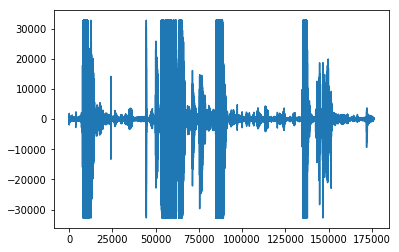

In [50]:
rate, s = wavfile.read('vocalizationcorpus/data/{}'.format(file))
plt.plot(s);
IPython.display.Audio(s, rate=rate)

In [51]:
res = model.predict([data_mfcc[[num]], data_filter[[num]]])[0]
res_noise = model.predict([data_mfcc_noise[[num]], data_filter_noise[[num]]])[0]

In [52]:
res

array([[[0.94376004, 0.05623997],
        [0.95778644, 0.04221354],
        [0.97415644, 0.02584356],
        [0.95444167, 0.0455583 ],
        [0.9778049 , 0.02219506],
        [0.9763169 , 0.02368308],
        [0.97368795, 0.026312  ],
        [0.9600588 , 0.03994112],
        [0.965176  , 0.03482406],
        [0.95415473, 0.04584529],
        [0.97425336, 0.02574668],
        [0.96701396, 0.03298603],
        [0.9626777 , 0.03732229],
        [0.98206997, 0.01793005],
        [0.982444  , 0.01755598],
        [0.9713752 , 0.02862473],
        [0.93883276, 0.06116726],
        [0.98027575, 0.01972425],
        [0.96322143, 0.03677859],
        [0.96121436, 0.03878566],
        [0.95246434, 0.04753567],
        [0.97708696, 0.02291304],
        [0.97543675, 0.02456324],
        [0.9700408 , 0.02995924],
        [0.98071676, 0.01928317],
        [0.97092587, 0.02907412],
        [0.9762296 , 0.02377045],
        [0.9520224 , 0.04797761],
        [0.9680425 , 0.03195748],
        [0.975

In [53]:
def plot_laugh_detection(res, data):
    cur_df = data[num]
    labels = cur_df[LABEL_NAME]
    plt.plot(np.array(range(labels.shape[0])), np.squeeze(res[0, :, 1]), np.array(range(labels.shape[0])), labels)

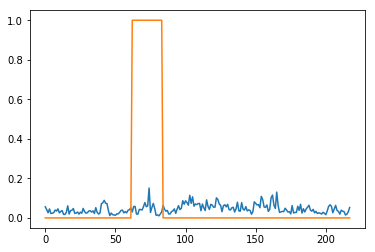

In [54]:
plot_laugh_detection(res, data)

In [55]:
num = 4
file = data_noise[num].loc[0, 'SNAME'] + '.wav'
file

'S2099.wav'

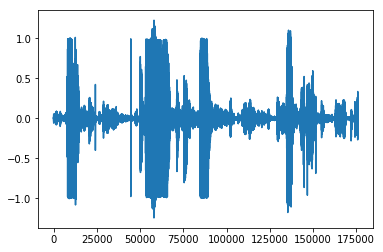

In [56]:
rate, s = wavfile.read('vocalizationcorpus/noise_data/{}'.format(file))
plt.plot(s);
IPython.display.Audio(s, rate=rate)

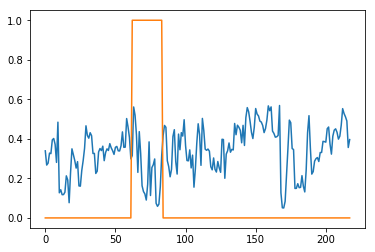

In [57]:
plot_laugh_detection(res_noise, data_noise)